Duplicate Dates:
 DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)
ADF Statistic: -1.539931907683837
p-value: 0.5136733116580245
Non-Stationary


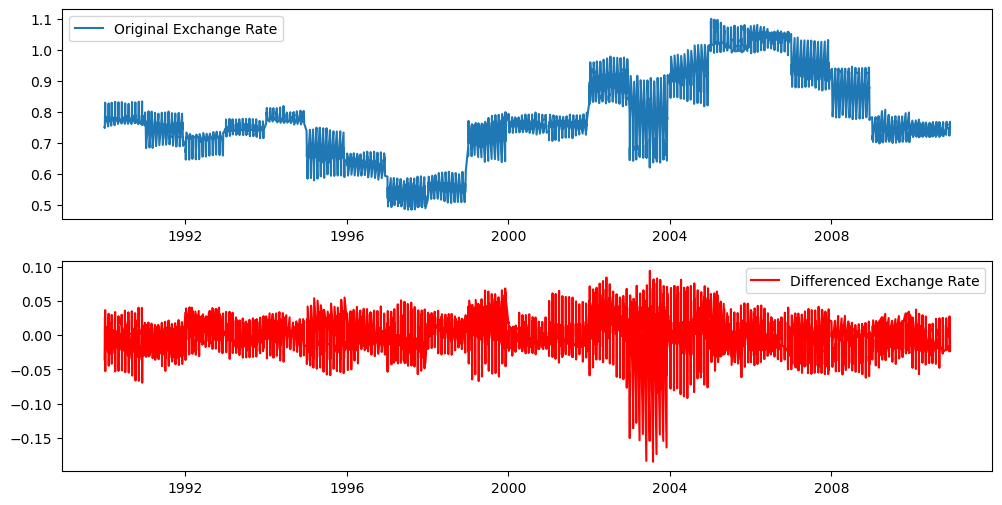

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\a

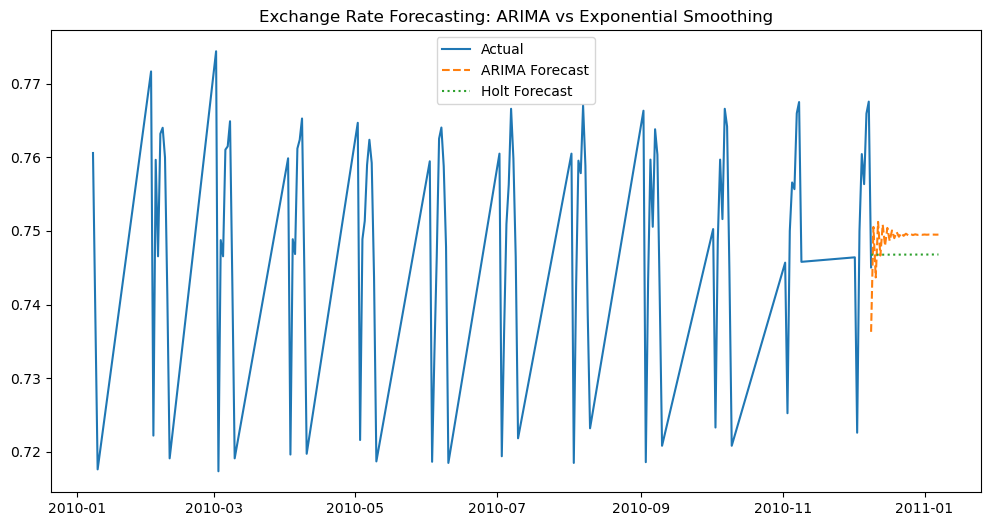

MAE: 0.011744991492409563, RMSE: 0.014551848389141472
MAE: 0.011865598547515602, RMSE: 0.014656173497660338


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
file_path = r"D:\Data since couress\Timeseries\Timeseries\exchange-rate.csv"
df = pd.read_csv(file_path, parse_dates=["date"], index_col="date", dayfirst=True)

# Convert index to Datetime format & remove duplicates
df.index = pd.to_datetime(df.index, errors='coerce')
df = df[~df.index.duplicated(keep="first")]
df.dropna(inplace=True)
# Check for duplicate dates
duplicates = df.index[df.index.duplicated()]
print("Duplicate Dates:\n", duplicates)

df = df[~df.index.duplicated(keep='first')]
df = df.asfreq('D')
df = df.asfreq('D', method="ffill")

# Ensure missing values are handled
#df["Ex_rate"] = df["Ex_rate"].ffill()
#df["Ex_rate"] = pd.to_numeric(df["Ex_rate"], errors="coerce")

# Ensure index has a consistent frequency
#df = df.asfreq('D', method="ffill")  # Forward-fill if missing dates exist

# ADF Test for Stationarity
def adf_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Stationary" if result[1] < 0.05 else "Non-Stationary")

adf_test(df["Ex_rate"])

# Apply differencing if non-stationary
df["Ex_rate_diff"] = df["Ex_rate"].diff()
df.dropna(inplace=True)

# Plot original & differenced series
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df.index, df["Ex_rate"], label="Original Exchange Rate")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df.index, df["Ex_rate_diff"], label="Differenced Exchange Rate", color='red')
plt.legend()
plt.show()

# Fit ARIMA Model
p, d, q = 2, 1, 2  
arima_model = ARIMA(df["Ex_rate"], order=(p, d, q)).fit()
arima_forecast = arima_model.forecast(steps=30)

# Fit Exponential Smoothing Model
holt_model = ExponentialSmoothing(df["Ex_rate"], trend="add").fit()
holt_forecast = holt_model.forecast(steps=30)

# Align forecast timestamps correctly
forecast_index = pd.date_range(start=df.index[-1], periods=30, freq='D')

# Forecast Visualization
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df["Ex_rate"].iloc[-100:], label="Actual")
plt.plot(forecast_index, arima_forecast.values, label="ARIMA Forecast", linestyle='dashed')
plt.plot(forecast_index, holt_forecast, label="Holt Forecast", linestyle='dotted')
plt.legend()
plt.title("Exchange Rate Forecasting: ARIMA vs Exponential Smoothing")
plt.show()

# Evaluation
def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f"MAE: {mae}, RMSE: {rmse}")

evaluate_forecast(df["Ex_rate"].iloc[-30:], arima_forecast)
evaluate_forecast(df["Ex_rate"].iloc[-30:], holt_forecast)